Exercises:</br>
E01: train a trigram language model, i.e. take two characters as an input to predict the 3rd one. Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?</br>
E02: split up the dataset randomly into 80% train set, 10% dev set, 10% test set. Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?</br>
E03: use the dev set to tune the strength of smoothing (or regularization) for the trigram model - i.e. try many possibilities and see which one works best based on the dev set loss. What patterns can you see in the train and dev set loss as you tune this strength? Take the best setting of the smoothing and evaluate on the test set once and at the end. How good of a loss do you achieve?</br>
E04: we saw that our 1-hot vectors merely select a row of W, so producing these vectors explicitly feels wasteful. Can you delete our use of F.one_hot in favor of simply indexing into rows of W?</br>
E05: look up and use F.cross_entropy instead. You should achieve the same result. Can you think of why we'd prefer to use F.cross_entropy instead?</br>
E06: meta-exercise! Think of a fun/interesting exercise and complete it.


In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
seed = 2147483647

In [3]:
with open("../names.txt", "r") as f:
    words = f.read().splitlines()

words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [4]:
len(words), min(len(w) for w in words), max(len(w) for w in words)

(32033, 2, 15)

## E01: train a trigram language model
i.e. take two characters as an input to predict the 3rd one. Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?

### Trigram Raw 1st approach - 27 x 27 x 27 Matrix

In [5]:
from collections import Counter

t_list = []
for w in words:
    chars = ["."]*2 + list(w)
    for ch1, ch2, ch3 in zip(chars, chars[1:], chars[2:]):
        trigram = (ch1, ch2, ch3)
        t_list.append(trigram)
        # print(ch1, ch2)

t_counter = Counter(t_list)
t = dict(t_counter)

In [6]:
t_counter

Counter({('.', '.', 'a'): 4410,
         ('.', '.', 'k'): 2963,
         ('.', '.', 'm'): 2538,
         ('.', '.', 'j'): 2422,
         ('.', '.', 's'): 2055,
         ('.', '.', 'd'): 1690,
         ('.', '.', 'r'): 1639,
         ('.', '.', 'l'): 1572,
         ('.', '.', 'c'): 1542,
         ('.', '.', 'e'): 1531,
         ('.', 'm', 'a'): 1453,
         ('.', '.', 't'): 1308,
         ('.', '.', 'b'): 1306,
         ('.', 'j', 'a'): 1255,
         ('.', 'k', 'a'): 1254,
         ('.', '.', 'n'): 1146,
         ('l', 'y', 'n'): 976,
         ('a', 'r', 'i'): 950,
         ('.', '.', 'z'): 929,
         ('.', '.', 'h'): 874,
         ('a', 'n', 'n'): 825,
         ('e', 'l', 'l'): 822,
         ('a', 'n', 'a'): 804,
         ('i', 'a', 'n'): 790,
         ('m', 'a', 'r'): 776,
         ('a', 'n', 'i'): 703,
         ('.', 'd', 'a'): 700,
         ('.', '.', 'g'): 669,
         ('i', 'y', 'a'): 669,
         ('l', 'a', 'n'): 647,
         ('.', 'b', 'r'): 646,
         ('n', 'n', 'a'

In [7]:
import torch

In [8]:
N = torch.zeros((27,27,27), dtype=torch.int32)

In [9]:
chars = sorted(list(set(''.join(words))))
s_to_i = {s: i + 1 for i, s in enumerate(chars)}
s_to_i["."] = 0
i_to_s = {i: s for s, i in s_to_i.items()}
i_to_s

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [10]:
for w in words:
    chars = ["."]*2 + list(w) + ["."]
    for ch1, ch2, ch3 in zip(chars, chars[1:], chars[2:]):
        ix1 = s_to_i[ch1]
        ix2 = s_to_i[ch2]
        ix3 = s_to_i[ch3]
        N[ix1, ix2, ix3] += 1

In [11]:
# import matplotlib.pyplot as plt
# %matplotlib inline
# plt.imshow(N)

In [12]:
# plt.figure(figsize=(16,16))
# plt.imshow(N, cmap="Blues")

# for i in range(27):
#     for j in range(27):
#         for k in range(27):
#             chstr = i_to_s[i] + i_to_s[j] + i_to_s[k]
#             plt.text(k, j, i, chstr, ha="center", va="bottom", color="gray")
#             plt.text(k, j, i, N[i,j,k].item(), ha="center", va="top", color="gray")

# plt.axis("off")

In [13]:
N[0][0]

tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929], dtype=torch.int32)

In [14]:
p = N[0][0].float()
p = p / p.sum()
p

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

In [15]:
g = torch.Generator().manual_seed(seed)
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
i_to_s[ix]

'j'

In [16]:
g = torch.Generator().manual_seed(seed)

In [17]:
N

tensor([[[   0, 4410, 1306,  ...,  134,  535,  929],
         [   0,  207,  190,  ...,   27,  173,  152],
         [   0,  169,    0,  ...,    0,    4,    0],
         ...,
         [   0,   57,    0,  ...,    1,   17,   11],
         [   0,  246,    0,  ...,    0,    0,    2],
         [   0,  456,    0,  ...,    0,   91,    1]],

        [[   0,    0,    0,  ...,    0,    0,    0],
         [  40,    0,    5,  ...,    0,   20,   11],
         [  36,   28,   20,  ...,    0,   12,    0],
         ...,
         [  11,    5,    0,  ...,   17,    6,    3],
         [ 163,  389,   13,  ...,    0,   16,   40],
         [  38,  123,    0,  ...,    0,   12,   22]],

        [[   0,    0,    0,  ...,    0,    0,    0],
         [  46,    5,    5,  ...,    4,   31,    4],
         [   1,    8,    0,  ...,    0,    9,    0],
         ...,
         [   0,    0,    0,  ...,    0,    0,    0],
         [  55,    4,    1,  ...,    0,    0,    0],
         [   0,    0,    0,  ...,    0,    0,    0]],

In [18]:
P = (N + 1).float()
P / P.sum(dim=2, keepdim=True)

tensor([[[3.1192e-05, 1.3759e-01, 4.0767e-02,  ..., 4.2109e-03,
          1.6719e-02, 2.9008e-02],
         [2.2538e-04, 4.6879e-02, 4.3047e-02,  ..., 6.3106e-03,
          3.9216e-02, 3.4483e-02],
         [7.5019e-04, 1.2753e-01, 7.5019e-04,  ..., 7.5019e-04,
          3.7509e-03, 7.5019e-04],
         ...,
         [6.2112e-03, 3.6025e-01, 6.2112e-03,  ..., 1.2422e-02,
          1.1180e-01, 7.4534e-02],
         [1.7794e-03, 4.3950e-01, 1.7794e-03,  ..., 1.7794e-03,
          1.7794e-03, 5.3381e-03],
         [1.0460e-03, 4.7803e-01, 1.0460e-03,  ..., 1.0460e-03,
          9.6234e-02, 2.0921e-03]],

        [[3.7037e-02, 3.7037e-02, 3.7037e-02,  ..., 3.7037e-02,
          3.7037e-02, 3.7037e-02],
         [7.0326e-02, 1.7153e-03, 1.0292e-02,  ..., 1.7153e-03,
          3.6021e-02, 2.0583e-02],
         [6.5141e-02, 5.1056e-02, 3.6972e-02,  ..., 1.7606e-03,
          2.2887e-02, 1.7606e-03],
         ...,
         [5.7416e-02, 2.8708e-02, 4.7847e-03,  ..., 8.6124e-02,
          3.349

In [19]:
tmp = torch.tensor(
    [
        [25, 25, 50],  # .a
        [30, 60, 10],  # .b
        [10, 20, 70],  # .c
        # ...
    ]
)

In [20]:
tmpa = (tmp / tmp.sum(dim=1, keepdim=True))
tmpa

tensor([[0.2500, 0.2500, 0.5000],
        [0.3000, 0.6000, 0.1000],
        [0.1000, 0.2000, 0.7000]])

In [21]:
tmpa[0].sum()

tensor(1.)

In [22]:
tmp_2 = torch.tensor(
    [
        [
            [25, 25, 50],  # .aa
            [30, 60, 10],  # .ab
            [10, 20, 70],  # .ac
            # ...
        ],
        [
            [20, 25, 55],  # .ba
            [15, 20, 65],  # .bb
            [10, 10, 80],  # .bc
            # ...
        ],
        [
            [20, 30, 50],  # .ca
            [33, 33, 33],  # .cb
            [0, 66, 33],  # .cc
            # ...
        ],

    ]
)

In [23]:
tmpb = (tmp_2 / tmp_2.sum(dim=2, keepdim=True))
tmpb

tensor([[[0.2500, 0.2500, 0.5000],
         [0.3000, 0.6000, 0.1000],
         [0.1000, 0.2000, 0.7000]],

        [[0.2000, 0.2500, 0.5500],
         [0.1500, 0.2000, 0.6500],
         [0.1000, 0.1000, 0.8000]],

        [[0.2000, 0.3000, 0.5000],
         [0.3333, 0.3333, 0.3333],
         [0.0000, 0.6667, 0.3333]]])

In [24]:
tmpb[0][0].sum()


tensor(1.)

In [25]:
(P / P[0].sum(dim=1, keepdim=True)).sum()


tensor(239.5950)

In [26]:
P = (N + 1).float()
P /= P.sum(dim=2, keepdim=True)

In [27]:
P[0][0].sum()

tensor(1.)

In [28]:
for i in range(5):
    i1x = 0
    i2x = 0
    char_list = []
    while i2x != 0 or not char_list:
        tmp = torch.multinomial(P[i1x][i2x], num_samples=1, replacement=True, generator=g).item()
        i1x = i2x
        i2x = tmp
        char_list.append(i_to_s[i2x])

    print(''.join(char_list[:-1]))

junide
jakasid
prelay
adin
kairritoper


In [29]:
# Goal: Maximize likelihood of data w.r.t. model parameters (statistical model)
# Equivalent to maximizing log-likelihood (because log is monotonic)
# Equivalent to minimizing negative log-likelihood
# Equivalent to minimizing the average negative log-likelihood

In [30]:
log_likelihood = 0.0
n = 0
# for w in words:
for w in ["andrejq"]:
    chars = ["."]*2 + list(w) + ["."]
    for ch1, ch2, ch3 in zip(chars, chars[1:], chars[2:]):
        ix1 = s_to_i[ch1]
        ix2 = s_to_i[ch2]
        ix3 = s_to_i[ch3]
        prob = P[ix1, ix2, ix3]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        # print(f"{ch1}{ch2}: {prob:.4f} {logprob:.4f}")
print(f"{log_likelihood=}")
nll = -log_likelihood
print(f"{nll=}")
print(f"{nll/n}")

log_likelihood=tensor(-22.4022)
nll=tensor(22.4022)
2.8002805709838867


### Trigram Raw 2nd approach - 729 x 27 Matrix

In [32]:
N = torch.zeros((27*27,27), dtype=torch.int32)

In [33]:
N.shape

torch.Size([729, 27])

In [34]:
chars = ["."] + sorted(list(set(''.join(words))))
char_tuples = [ch1 + ch2 for ch1 in chars for ch2 in chars]
char_tuples

['..',
 '.a',
 '.b',
 '.c',
 '.d',
 '.e',
 '.f',
 '.g',
 '.h',
 '.i',
 '.j',
 '.k',
 '.l',
 '.m',
 '.n',
 '.o',
 '.p',
 '.q',
 '.r',
 '.s',
 '.t',
 '.u',
 '.v',
 '.w',
 '.x',
 '.y',
 '.z',
 'a.',
 'aa',
 'ab',
 'ac',
 'ad',
 'ae',
 'af',
 'ag',
 'ah',
 'ai',
 'aj',
 'ak',
 'al',
 'am',
 'an',
 'ao',
 'ap',
 'aq',
 'ar',
 'as',
 'at',
 'au',
 'av',
 'aw',
 'ax',
 'ay',
 'az',
 'b.',
 'ba',
 'bb',
 'bc',
 'bd',
 'be',
 'bf',
 'bg',
 'bh',
 'bi',
 'bj',
 'bk',
 'bl',
 'bm',
 'bn',
 'bo',
 'bp',
 'bq',
 'br',
 'bs',
 'bt',
 'bu',
 'bv',
 'bw',
 'bx',
 'by',
 'bz',
 'c.',
 'ca',
 'cb',
 'cc',
 'cd',
 'ce',
 'cf',
 'cg',
 'ch',
 'ci',
 'cj',
 'ck',
 'cl',
 'cm',
 'cn',
 'co',
 'cp',
 'cq',
 'cr',
 'cs',
 'ct',
 'cu',
 'cv',
 'cw',
 'cx',
 'cy',
 'cz',
 'd.',
 'da',
 'db',
 'dc',
 'dd',
 'de',
 'df',
 'dg',
 'dh',
 'di',
 'dj',
 'dk',
 'dl',
 'dm',
 'dn',
 'do',
 'dp',
 'dq',
 'dr',
 'ds',
 'dt',
 'du',
 'dv',
 'dw',
 'dx',
 'dy',
 'dz',
 'e.',
 'ea',
 'eb',
 'ec',
 'ed',
 'ee',
 'ef',
 'eg',

In [35]:
big_s_to_i = {char_tuple: i for i, char_tuple in enumerate(char_tuples)}
big_i_to_s = {i: s for s, i in big_s_to_i.items()}
big_i_to_s

{0: '..',
 1: '.a',
 2: '.b',
 3: '.c',
 4: '.d',
 5: '.e',
 6: '.f',
 7: '.g',
 8: '.h',
 9: '.i',
 10: '.j',
 11: '.k',
 12: '.l',
 13: '.m',
 14: '.n',
 15: '.o',
 16: '.p',
 17: '.q',
 18: '.r',
 19: '.s',
 20: '.t',
 21: '.u',
 22: '.v',
 23: '.w',
 24: '.x',
 25: '.y',
 26: '.z',
 27: 'a.',
 28: 'aa',
 29: 'ab',
 30: 'ac',
 31: 'ad',
 32: 'ae',
 33: 'af',
 34: 'ag',
 35: 'ah',
 36: 'ai',
 37: 'aj',
 38: 'ak',
 39: 'al',
 40: 'am',
 41: 'an',
 42: 'ao',
 43: 'ap',
 44: 'aq',
 45: 'ar',
 46: 'as',
 47: 'at',
 48: 'au',
 49: 'av',
 50: 'aw',
 51: 'ax',
 52: 'ay',
 53: 'az',
 54: 'b.',
 55: 'ba',
 56: 'bb',
 57: 'bc',
 58: 'bd',
 59: 'be',
 60: 'bf',
 61: 'bg',
 62: 'bh',
 63: 'bi',
 64: 'bj',
 65: 'bk',
 66: 'bl',
 67: 'bm',
 68: 'bn',
 69: 'bo',
 70: 'bp',
 71: 'bq',
 72: 'br',
 73: 'bs',
 74: 'bt',
 75: 'bu',
 76: 'bv',
 77: 'bw',
 78: 'bx',
 79: 'by',
 80: 'bz',
 81: 'c.',
 82: 'ca',
 83: 'cb',
 84: 'cc',
 85: 'cd',
 86: 'ce',
 87: 'cf',
 88: 'cg',
 89: 'ch',
 90: 'ci',
 91: 'cj'

In [36]:
tiny_s_to_i = {char: i for i, char in enumerate(chars)}
tiny_i_to_s = {i: s for s, i in tiny_s_to_i.items()}
tiny_i_to_s

{0: '.',
 1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z'}

In [37]:
for w in words:
    chars = ["."]*2 + list(w) + ["."]
    for ch1, ch2, ch3 in zip(chars, chars[1:], chars[2:]):
        best_friends = ch1 + ch2
        ix1 = big_s_to_i[best_friends]
        ix2 = tiny_s_to_i[ch3]
        N[ix1, ix2] += 1

In [38]:
N[0]

tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929], dtype=torch.int32)

In [39]:
p = N[0].float()
p = p / p.sum()
p

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

In [40]:
g = torch.Generator().manual_seed(seed)
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
tiny_i_to_s[ix]

'j'

In [41]:
N

tensor([[   0, 4410, 1306,  ...,  134,  535,  929],
        [   0,  207,  190,  ...,   27,  173,  152],
        [   0,  169,    0,  ...,    0,    4,    0],
        ...,
        [   1,    0,    0,  ...,    0,    0,    0],
        [  34,   27,    0,  ...,    0,    0,    1],
        [   4,   13,    0,  ...,    0,    7,    0]], dtype=torch.int32)

In [42]:
P = (N + 1).float()
P /= P.sum(dim=1, keepdim=True)

In [43]:
P[0].sum()

tensor(1.)

In [44]:
# probabilites = torch.zeros((27,27,27), dtype=torch.float32)
# for i in range(27):
#     probabilites[i] = N[i].float() / N[i].sum().float()

g = torch.Generator().manual_seed(seed)

i1x = 0
i2x = None
char_list = []
while i2x != 0 or not char_list:
    i2x = torch.multinomial(P[i1x], num_samples=1, replacement=True, generator=g).item()
    new_chars = big_i_to_s[i1x][1] + tiny_i_to_s[i2x]
    char_list.append(tiny_i_to_s[i2x])
    i1x = big_s_to_i[new_chars]


''.join(char_list[:-1])

'junide'

In [45]:
# Goal: Maximize likelihood of data w.r.t. model parameters (statistical model)
# Equivalent to maximizing log-likelihood (because log is monotonic)
# Equivalent to minimizing negative log-likelihood
# Equivalent to minimizing the average negative log-likelihood

In [46]:
log_likelihood = 0.0
n = 0
# for w in words:
for w in ["andrejq"]:
    chars = ["."]*2 + list(w) + ["."]
    for ch1, ch2, ch3 in zip(chars, chars[1:], chars[2:]):
        best_friends = ch1 + ch2
        ix1 = big_s_to_i[best_friends]
        ix2 = tiny_s_to_i[ch3]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        # print(f"{ch1}{ch2}: {prob:.4f} {logprob:.4f}")
print(f"{log_likelihood=}")
nll = -log_likelihood
print(f"{nll=}")
print(f"{nll/n}")

log_likelihood=tensor(-22.4022)
nll=tensor(22.4022)
2.8002805709838867


Output for bigram:
```
log_likelihood=tensor(-27.8672)
nll=tensor(27.8672)
3.4834020137786865
```

### Trigram Neural Net

#### Borrowed answer

In [5]:
N = torch.zeros((27, 27, 27), dtype=torch.int32)

In [6]:
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}

In [7]:
for w in words:
    chs = ["."] + list(w) + ["."]
    # print(chs, chs[1:])
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        N[ix1, ix2, ix3] += 1

In [8]:
N[0][0]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0], dtype=torch.int32)

In [10]:
N[0][1]

tensor([  0, 207, 190,  31, 366,  55,  21,  17,  91, 154,  27,  75, 632, 384,
        623,  10,  17,   9, 482, 194,  72, 152, 243,   6,  27, 173, 152],
       dtype=torch.int32)

In [10]:
p = N[0][1].float()    #tri-gram, so it takes 2 letters or 2 int here.
p = p / p.sum()
p.shape

torch.Size([27])

In [12]:
g = torch.Generator().manual_seed(seed)
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
itos[ix]

'l'

In [13]:
g = torch.Generator().manual_seed(seed)
p = torch.rand(3, generator=g)
p = p / p.sum()
p

tensor([0.6064, 0.3033, 0.0903])

In [11]:
P = (N+1).float()
P /= P.sum(2, keepdims=True)

In [12]:
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
    out = []
    ix, jx = 0, 0
    while True:
      p = P[ix][jx]
      next_letter = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
      ix = jx
      jx = next_letter
      out.append(itos[next_letter])
      if next_letter == 0:
        break
    print(''.join(out))

junide.
ilyasid.
prelay.
ocin.
fairritoper.


In [13]:
log_likelihood = 0.0
n = 0

for w in words:
#for w in ["andrejq"]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    ix3 = stoi[ch3]
    prob = P[ix1, ix2, ix3]
    logprob = torch.log(prob)
    log_likelihood += logprob
    n += 1
    #print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')

print(f'{log_likelihood}')
nll = -log_likelihood
print(f'{nll}')
print(f'{nll/n}')

-410414.96875
410414.96875
2.092747449874878


In [14]:
# create the training set of tr-igrams (x,y)
xs, ys = [], []
print("Orginal word: ", words[:1])
for w in words[:1]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    ix3 = stoi[ch3]
    print(ch1, ch2, ch3)
    xs.append([ix1, ix2])
    ys.append(ix3)

    
xs = torch.tensor(xs)
ys = torch.tensor(ys)

Orginal word:  ['emma']
. e m
e m m
m m a
m a .


In [15]:
xs

tensor([[ 0,  5],
        [ 5, 13],
        [13, 13],
        [13,  1]])

In [16]:
ys

tensor([13, 13,  1,  0])

In [17]:
import torch.nn.functional as F
xenc: torch.Tensor = F.one_hot(xs, num_classes=27).float()
xenc

tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.,

In [19]:
xenc.dtype, xenc.shape

(torch.float32, torch.Size([4, 2, 27]))

In [20]:
W = torch.randn((27*2, 1))
out1 = xenc.view(4, -1) @ W
out1.shape

torch.Size([4, 1])

In [35]:
logits = xenc.view(4, -1) @ W # log-counts
counts = logits.exp() # equivalent N
probs = counts / counts.sum(1, keepdims=True)
probs

tensor([[1.],
        [1.],
        [1.],
        [1.]])

In [29]:
import torch

# Create a 2D tensor with 4 rows and 3 columns
tensor = torch.tensor([[1, 2, 3],
                       [4, 5, 6],
                       [7, 8, 9],
                       [10, 11, 12]])

# Use view to reshape it to 3 rows and 4 columns
reshaped_tensor = tensor.view(3, 4)

# The data stays the same, but the shape is different
print(reshaped_tensor)


tensor([[ 1,  2,  3,  4],
        [ 5,  6,  7,  8],
        [ 9, 10, 11, 12]])


In [36]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27*2, 27), generator=g)

In [37]:
xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
logits = xenc.view(-1, 27*2) @ W # predict log-counts
counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
# btw: the last 2 lines here are together called a 'softmax'

In [38]:
probs.shape

torch.Size([4, 27])

In [41]:
xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
logits = xenc.view(4, 2*27) @ W # predict log-counts
counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
loss = -probs[torch.arange(4), ys].log().mean()

In [43]:
loss

tensor(4.0953)

In [44]:
xs, ys = [], []
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    ix3 = stoi[ch3]
    xs.append([ix1, ix2])
    ys.append(ix3)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()


# initialize the 'network'
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27*2, 27), generator=g, requires_grad=True)

In [45]:
# gradient descent
for k in range(100):
  
  # forward pass
  xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
  logits = xenc.view(-1, 27*2) @ W # predict log-counts
  counts = logits.exp() # counts, equivalent to N
  probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
  loss = -probs[torch.arange(ys.shape[0]), ys].log().mean() + 0.01*(W**2).mean()    #divided by 2 because we have a bigram here
  if(k>95):
    print(loss.item())
  
  # backward pass
  W.grad = None # set to zero the gradient
  loss.backward()
  
  # update
  W.data += -50 * W.grad

2.2735965251922607
2.2732994556427
2.2730088233947754
2.272723436355591


In [47]:
import random

In [48]:
# finally, sample from the 'neural net' model
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
  
  out = []
  ix = 0
  iy = random.randint(1, 26)
  while True:
    
    # ----------
    # BEFORE:
    #p = P[ix]
    # ----------
    # NOW:
    xenc = F.one_hot(torch.tensor([ix, iy]), num_classes=27).float()
    logits = xenc.view(-1, 27*2) @ W # predict log-counts
    counts = logits.exp() # counts, equivalent to N
    p = counts / counts.sum(1, keepdims=True) # probabilities for next character
    # ----------
    
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

uunidmduauagaduuuufaauaunuamuuinltoliauuauuumuuamnaauuamulemaasudbduinrwiuulusnouinaulautuuunvuumruafoutuuuuufuusuuauruauuuuoraayaeuouuuauaauumuuufmuuimxyninuagaasnumufiuuusuxhxdgoufuuuauuiuu.
ujuuuluuumu.
rtroeri.
iaa.
oyei.


#### 27 x 54 Matrix

In [5]:
chars = sorted(list(set(''.join(words))))
s_to_i = {s: i + 1 for i, s in enumerate(chars)}
s_to_i["."] = 0
i_to_s = {i: s for s, i in s_to_i.items()}

In [6]:
# create the dataset
xs, ys = [], []
for w in words:
    chs = ["."] * 2 + list(w) + ["."]
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        input_x_1 = s_to_i[ch1]
        input_x_2 = s_to_i[ch2]
        output_y = s_to_i[ch3]
        xs.append((input_x_1, input_x_2))
        ys.append(output_y)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print("number of examples: ", num)

# initialize the 'network'
g = torch.Generator().manual_seed(seed)
W = torch.randn((27*2, 27), generator=g, requires_grad=True)

number of examples:  456292


In [7]:
xs.nelement(), ys.nelement()

(456292, 228146)

In [8]:
xs

tensor([[ 0,  0],
        [ 0,  5],
        [ 5, 13],
        ...,
        [26, 25],
        [25, 26],
        [26, 24]])

In [9]:
y_num = ys.nelement()

# gradient descent
for k in range(100):
    # forward pass
    xenc: torch.Tensor = F.one_hot(xs, num_classes=27).float()  # input to the network: one-hot encoding
    logits = xenc.view(-1, 2*27) @ W  # predict log-counts
    counts = logits.exp()  # counts, equivalent to N
    probs = counts / counts.sum(1, keepdims=True)  # probabilities for next character
    loss = -probs[torch.arange(y_num), ys].log().mean() + 0.01 * (W**2).mean()
    if (k % 10) == 0:
        print(loss.item())

    # backward pass
    W.grad = None  # set to zero the gradient
    loss.backward()

    # update
    W.data += -50 * W.grad

4.242241859436035
2.6331708431243896
2.5102314949035645
2.4684457778930664
2.43998646736145
2.4310684204101562
2.4142682552337646
2.415776014328003
2.4012656211853027
2.4072725772857666


In [12]:
# finally, sample from the 'neural net' model
g = torch.Generator().manual_seed(seed)

for i in range(5):
    out = []
    ix1 = 0
    ix2 = 0
    while True:
        # ----------
        # BEFORE:
        # p = P[ix]
        # ----------
        # NOW:
        xenc: torch.Tensor = F.one_hot(torch.tensor([ix1, ix2]), num_classes=27).float()
        logits = xenc.view(-1, 2*27) @ W  # predict log-counts
        counts = logits.exp()  # counts, equivalent to N
        p = counts / counts.sum(1, keepdims=True)  # probabilities for next character
        # ----------

        iy = torch.multinomial(
            p, num_samples=1, replacement=True, generator=g
        ).item()
        out.append(i_to_s[iy])
        ix1 = ix2 #s_to_i[i_to_s[ix] + i_to_s[new_ix]]
        ix2 = iy
        if iy == 0:
            break
    print("".join(out))

juwide.
janasaz.
pariay.
ainn.
kai.


#### 729 x 27 Matrix

In [45]:
# create the dataset
xs, ys = [], []
for w in words:
    chs = ["."] * 2 + list(w) + ["."]
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        input_x = big_s_to_i[ch1 + ch2]
        output_y = tiny_s_to_i[ch3]
        xs.append(input_x)
        ys.append(output_y)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print("number of examples: ", num)

# initialize the 'network'
g = torch.Generator().manual_seed(seed)
W = torch.randn((729, 27), generator=g, requires_grad=True)

number of examples:  228146


In [46]:
import torch.nn.functional as F

In [48]:
xenc = F.one_hot(xs, num_classes=27 * 27).float()  # input to the network: one-hot encoding
xenc

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

In [49]:
xenc.shape

torch.Size([228146, 729])

In [51]:
# gradient descent
for k in range(300):
    # forward pass
    xenc = F.one_hot(xs, num_classes=27 * 27).float()  # input to the network: one-hot encoding
    logits = xenc @ W  # predict log-counts
    counts = logits.exp()  # counts, equivalent to N
    probs = counts / counts.sum(1, keepdims=True)  # probabilities for next character
    loss = -probs[torch.arange(num), ys].log().mean() + 0.01 * (W**2).mean()
    if (k % 10) == 0:
        print(loss.item())

    # backward pass
    W.grad = None  # set to zero the gradient
    loss.backward()

    # update with learning rate decay
    W.data += -50 * W.grad / (1 + k*0.8 / 100)


3.8028223514556885
3.20821475982666
2.999692916870117
2.8769445419311523
2.7955620288848877
2.737734079360962
2.6941769123077393
2.6598358154296875
2.6318471431732178
2.6084728240966797
2.5885837078094482
2.5714097023010254
2.556401014328003
2.5431525707244873
2.531357526779175
2.5207793712615967
2.51123046875
2.502561092376709
2.494649887084961
2.4873976707458496
2.4807214736938477
2.474552631378174
2.46883225440979
2.4635117053985596
2.458547592163086
2.453904151916504
2.449549913406372
2.4454572200775146
2.441601514816284
2.437962532043457


bigram:
```
2.6608054637908936
2.5711233615875244
2.536261796951294
2.5184857845306396
2.5081682205200195
2.501594305038452
2.4970998764038086
2.4938690662384033
2.491464376449585
2.489628791809082
```

In [55]:
# finally, sample from the 'neural net' model
g = torch.Generator().manual_seed(seed)

for i in range(5):
    out = []
    ix = 0
    while True:
        # ----------
        # BEFORE:
        # p = P[ix]
        # ----------
        # NOW:
        xenc = F.one_hot(torch.tensor([ix]), num_classes=27 * 27).float()
        logits = xenc @ W  # predict log-counts
        counts = logits.exp()  # counts, equivalent to N
        p = counts / counts.sum(1, keepdims=True)  # probabilities for next character
        # ----------

        new_ix = torch.multinomial(
            p, num_samples=1, replacement=True, generator=g
        ).item()
        out.append(tiny_i_to_s[new_ix])
        ix = big_s_to_i[big_i_to_s[ix][1] + tiny_i_to_s[new_ix]]
        if new_ix == 0:
            break
    print("".join(out))

juwjded.
anaqah.
pxzxqywocnzq.
jimrttohcaus.
ter.


## E02: split up the dataset randomly into 80% train set, 10% dev set, 10% test set.
#### Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?</br>

In [5]:
# Shuffle the data
import random

random.seed(seed)

tmp_words = words.copy()
random.shuffle(tmp_words)

# create the dataset
train_words, val_words, test_words = (
    tmp_words[: int(0.8 * len(tmp_words))],
    tmp_words[int(0.8 * len(tmp_words)) : int(0.9 * len(tmp_words))],
    tmp_words[int(0.9 * len(tmp_words)) :],
)

### Counting

In [54]:
def get_probability_matrix(words: list[str], is_trigram: bool = True, smoothing_factor: int = 1):
    dim = (27, 27, 27) if is_trigram else (27, 27)
    N = torch.zeros(dim, dtype=torch.int32)

    chars = sorted(list(set("".join(words))))
    s_to_i = {s: i + 1 for i, s in enumerate(chars)}
    s_to_i["."] = 0
    i_to_s = {i: s for s, i in s_to_i.items()}

    for w in words:
        chars = ["."] * (1 + is_trigram) + list(w) + ["."]
        for ch1, ch2, ch3 in zip(chars, chars[1:], chars[1 + is_trigram :]):
            ix1 = s_to_i[ch1]
            ix2 = s_to_i[ch2]
            if is_trigram:
                ix3 = s_to_i[ch3]
                N[ix1, ix2, ix3] += 1
            else:
                N[ix1, ix2] += 1

    P = (N + smoothing_factor).float()
    P /= P.sum(dim=1 + is_trigram, keepdim=True)

    return P, s_to_i, i_to_s


def get_loss(words: list[str], P, s_to_i, i_to_s, is_trigram: bool = True, silent = False):
    log_likelihood = 0.0
    n = 0
    for w in words:
        chars = ["."] * (1 + is_trigram) + list(w) + ["."]
        for ch1, ch2, ch3 in zip(chars, chars[1:], chars[1 + is_trigram :]):
            ix1 = s_to_i[ch1]
            ix2 = s_to_i[ch2]
            if is_trigram:
                ix3 = s_to_i[ch3]
                prob = P[ix1, ix2, ix3]
            else:
                prob = P[ix1, ix2]
            logprob = torch.log(prob)
            log_likelihood += logprob
            n += 1
    nll = -log_likelihood
    if not silent:
        print(f"{log_likelihood=}")
        print(f"{nll=}")
        print(f"{nll/n}")
    return nll / n

In [69]:
get_loss(["andrejq"], *get_probability_matrix(words))

log_likelihood=tensor(-22.4022)
nll=tensor(22.4022)
2.8002805709838867


tensor(2.8003)

In [86]:
get_loss(["andrejq"], *get_probability_matrix(words, is_trigram=False), is_trigram=False)

log_likelihood=tensor(-27.8672)
nll=tensor(27.8672)
3.4834020137786865


tensor(3.4834)

In [ ]:
get_loss(words, *get_probability_matrix(words))


log_likelihood=tensor(-504653.)
nll=tensor(504653.)
2.2119739055633545


tensor(2.2120)

In [87]:
get_loss(words, *get_probability_matrix(words, is_trigram=False), is_trigram=False)


log_likelihood=tensor(-559951.5625)
nll=tensor(559951.5625)
2.4543561935424805


tensor(2.4544)

In [88]:
P_2, s_to_i, i_to_s = get_probability_matrix(train_words, is_trigram=False)
P_3, s_to_i, i_to_s = get_probability_matrix(train_words)

In [90]:
for data_set, data_name in [(train_words, "train"), (val_words, "val"), (test_words, "test")]:
    print(f"{data_name=}")
    get_loss(data_set, P_2, s_to_i, i_to_s, is_trigram=False)
    print()


data_name='train'
log_likelihood=tensor(-448232.8750)
nll=tensor(448232.8750)
2.455451726913452

data_name='val'
log_likelihood=tensor(-56076.6719)
nll=tensor(56076.6719)
2.455195903778076

data_name='test'
log_likelihood=tensor(-55794.8945)
nll=tensor(55794.8945)
2.4514453411102295



In [91]:
for data_set, data_name in [(train_words, "train"), (val_words, "val"), (test_words, "test")]:
    print(f"{data_name=}")
    get_loss(data_set, P_3, s_to_i, i_to_s)
    print()


data_name='train'
log_likelihood=tensor(-404414.3438)
nll=tensor(404414.3438)
2.2154107093811035

data_name='val'
log_likelihood=tensor(-51308.7266)
nll=tensor(51308.7266)
2.246441602706909

data_name='test'
log_likelihood=tensor(-50781.2344)
nll=tensor(50781.2344)
2.23116135597229



## E03: use the dev set to tune the strength of smoothing (or regularization) for the trigram model
#### i.e. try many possibilities and see which one works best based on the dev set loss. What patterns can you see in the train and dev set loss as you tune this strength? Take the best setting of the smoothing and evaluate on the test set once and at the end. How good of a loss do you achieve?</br>

### Counting

In [55]:
losses = []
for i in range(0, 1000):
    P, s_to_i, i_to_s = get_probability_matrix(train_words, smoothing_factor=i)
    losses.append(get_loss(val_words, P, s_to_i, i_to_s))
    

log_likelihood=tensor(nan)
nll=tensor(nan)
nan
log_likelihood=tensor(-51308.7266)
nll=tensor(51308.7266)
2.246441602706909
log_likelihood=tensor(-51739.4609)
nll=tensor(51739.4609)
2.2653002738952637
log_likelihood=tensor(-52128.5117)
nll=tensor(52128.5117)
2.282334089279175
log_likelihood=tensor(-52483.6172)
nll=tensor(52483.6172)
2.297881603240967
log_likelihood=tensor(-52811.7188)
nll=tensor(52811.7188)
2.312246799468994
log_likelihood=tensor(-53116.9766)
nll=tensor(53116.9766)
2.3256118297576904
log_likelihood=tensor(-53403.7148)
nll=tensor(53403.7148)
2.3381662368774414
log_likelihood=tensor(-53674.4766)
nll=tensor(53674.4766)
2.3500208854675293
log_likelihood=tensor(-53930.2500)
nll=tensor(53930.2500)
2.3612194061279297
log_likelihood=tensor(-54173.8633)
nll=tensor(54173.8633)
2.3718855381011963
log_likelihood=tensor(-54405.5078)
nll=tensor(54405.5078)
2.3820273876190186
log_likelihood=tensor(-54626.9805)
nll=tensor(54626.9805)
2.391724109649658
log_likelihood=tensor(-54840.5547)

KeyboardInterrupt: 

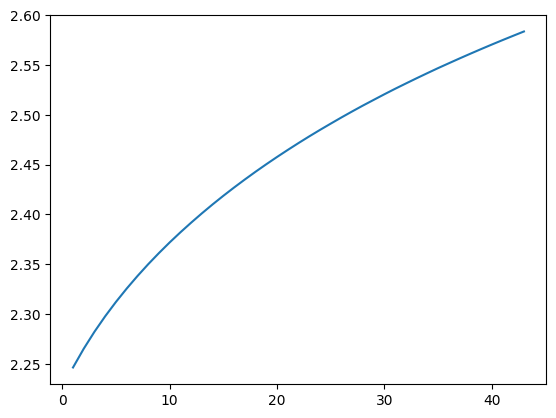

0

In [56]:
# plot the losses
import matplotlib.pyplot as plt

plt.plot(losses)
plt.show()

# get the best smoothing factor
best_smoothing_factor = torch.tensor(losses).argmin().item()
best_smoothing_factor

### Neural Net

In [14]:
chars = sorted(list(set(''.join(words))))
s_to_i = {s: i + 1 for i, s in enumerate(chars)}
s_to_i["."] = 0
i_to_s = {i: s for s, i in s_to_i.items()}

In [23]:
def dataset_from_words(words: list[str], s_to_i: dict[str, int]):
    xs, ys = [], []
    for w in words:
        chs = ["."] * 2 + list(w) + ["."]
        for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
            input_x_1 = s_to_i[ch1]
            input_x_2 = s_to_i[ch2]
            output_y = s_to_i[ch3]
            xs.append((input_x_1, input_x_2))
            ys.append(output_y)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    print("number of examples: ", ys.nelement())
    return xs, ys

def train_nn(xs: torch.Tensor, ys: torch.Tensor, regularization: float = 0.01):
    # initialize the 'network'
    g = torch.Generator().manual_seed(seed)
    W = torch.randn((27*2, 27), generator=g, requires_grad=True)

    y_num = ys.nelement()

    # gradient descent
    for k in range(100):
        # forward pass
        xenc: torch.Tensor = F.one_hot(xs, num_classes=27).float()  # input to the network: one-hot encoding
        logits = xenc.view(-1, 2*27) @ W  # predict log-counts
        counts = logits.exp()  # counts, equivalent to N
        probs = counts / counts.sum(1, keepdims=True)  # probabilities for next character
        loss: torch.Tensor = -probs[torch.arange(y_num), ys].log().mean() + regularization * (W**2).mean()

        if (k % 20) == 0:
            print(loss.item())
        # backward pass
        W.grad = None  # set to zero the gradient
        loss.backward()
        # update
        W.data += -50 * W.grad
    return W

def compute_loss(W: torch.Tensor, xs: torch.Tensor, ys: torch.Tensor, regularization: float = 0.01):
    y_num = ys.nelement()
    xenc: torch.Tensor = F.one_hot(xs, num_classes=27).float()  # input to the network: one-hot encoding
    logits = xenc.view(-1, 2*27) @ W  # predict log-counts
    counts = logits.exp()  # counts, equivalent to N
    probs = counts / counts.sum(1, keepdims=True)  # probabilities for next character
    loss: torch.Tensor = -probs[torch.arange(y_num), ys].log().mean() + regularization * (W**2).mean()
    return loss

In [24]:
train_xs, train_ys = dataset_from_words(train_words, s_to_i)
val_xs, val_ys = dataset_from_words(val_words, s_to_i)
test_xs, test_ys = dataset_from_words(test_words, s_to_i)

number of examples:  182546
number of examples:  22840
number of examples:  22760


In [25]:
losses = []
for i in range(100):
    print(f"Regularization: {i/100}")
    W = train_nn(train_xs, train_ys, regularization=i/100)
    losses.append(compute_loss(W, val_xs, val_ys, regularization=i/100))
    print(losses[-1])
    print()

Regularization: 0.0
4.2332444190979
2.5049571990966797
2.4339613914489746
2.4076805114746094
2.393829107284546
tensor(2.3876, grad_fn=<AddBackward0>)

Regularization: 0.01
4.242944717407227
2.5112154483795166
2.440770387649536
2.414987325668335
2.4017438888549805
tensor(2.3961, grad_fn=<AddBackward0>)

Regularization: 0.02
4.252645015716553
2.5172061920166016
2.44711971282959
2.421684980392456
2.4089560508728027
tensor(2.4037, grad_fn=<AddBackward0>)

Regularization: 0.03
4.262345790863037
2.5229427814483643
2.453049659729004
2.427856683731079
2.4155702590942383
tensor(2.4106, grad_fn=<AddBackward0>)

Regularization: 0.04
4.272046089172363
2.5284337997436523
2.4585916996002197
2.43357253074646
2.42167329788208
tensor(2.4169, grad_fn=<AddBackward0>)

Regularization: 0.05
4.2817463874816895
2.533688545227051
2.4637739658355713
2.438890218734741
2.4273335933685303
tensor(2.4228, grad_fn=<AddBackward0>)

Regularization: 0.06
4.291446685791016
2.53872013092041
2.46863055229187
2.44386792182

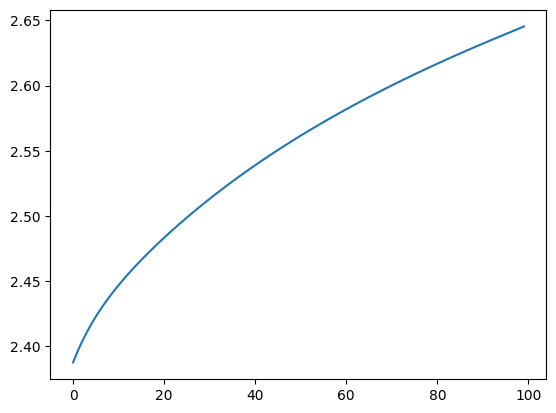

In [27]:
plt.plot([loss.item() for loss in losses])

## E04: we saw that our 1-hot vectors merely select a row of W, so producing these vectors explicitly feels wasteful.
#### Can you delete our use of F.one_hot in favor of simply indexing into rows of W?</br>

In [6]:
chars = sorted(list(set(''.join(words))))
s_to_i = {s: i + 1 for i, s in enumerate(chars)}
s_to_i["."] = 0
i_to_s = {i: s for s, i in s_to_i.items()}

In [7]:
# create the dataset
xs, ys = [], []
for w in words:
    chs = ["."] * 2 + list(w) + ["."]
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        input_x_1 = s_to_i[ch1]
        input_x_2 = s_to_i[ch2]
        output_y = s_to_i[ch3]
        xs.append((input_x_1, input_x_2))
        ys.append(output_y)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print("number of examples: ", num)

# initialize the 'network'
g = torch.Generator().manual_seed(seed)
W = torch.randn((27*2, 27), generator=g, requires_grad=True)

number of examples:  456292


In [8]:
xs.nelement(), ys.nelement()

(456292, 228146)

In [94]:
y_num = ys.nelement()

# gradient descent
for k in range(100):
    # forward pass
    # xenc: torch.Tensor = F.one_hot(xs, num_classes=27).float()  # input to the network: one-hot encoding
    # logits = xenc.view(-1, 2*27) @ W  # predict log-counts
    W_first_half = torch.stack([W[x[0]] for x in xs])
    W_second_half = torch.stack([W[x[1]+27] for x in xs])
    logits = W_first_half + W_second_half
    # logits = torch.stack([W[x[0]] + W[x[1]+27] for x in xs])
    counts = logits.exp()  # counts, equivalent to N
    probs = counts / counts.sum(1, keepdims=True)  # probabilities for next character
    loss = -probs[torch.arange(y_num), ys].log().mean() + 0.01 * (W**2).mean()
    if (k % 10) == 0:
        print(loss.item())

    # backward pass
    W.grad = None  # set to zero the gradient
    loss.backward()

    # update
    W.data += -50 * W.grad

2.4997568130493164
2.4894626140594482
2.4559082984924316
2.4694080352783203
2.433418035507202


KeyboardInterrupt: 

In [95]:
# finally, sample from the 'neural net' model
g = torch.Generator().manual_seed(seed)

for i in range(5):
    out = []
    ix1 = 0
    ix2 = 0
    while True:
        # ----------
        # BEFORE:
        # p = P[ix]
        # ----------
        # NOW:
        xenc: torch.Tensor = F.one_hot(torch.tensor([ix1, ix2]), num_classes=27).float()
        logits = xenc.view(-1, 2*27) @ W  # predict log-counts
        counts = logits.exp()  # counts, equivalent to N
        p = counts / counts.sum(1, keepdims=True)  # probabilities for next character
        # ----------

        iy = torch.multinomial(
            p, num_samples=1, replacement=True, generator=g
        ).item()
        out.append(i_to_s[iy])
        ix1 = ix2 #s_to_i[i_to_s[ix] + i_to_s[new_ix]]
        ix2 = iy
        if iy == 0:
            break
    print("".join(out))

juwide.
janasaz.
alen.
amainn.
kai.


In [ ]:
# juwide.
# janasaz.
# pariay.
# ainn.
# kai.

## E05: look up and use F.cross_entropy instead. You should achieve the same result.
#### Can you think of why we'd prefer to use F.cross_entropy instead?</br>

In [96]:
# def train_nn_cross_entropy(xs: torch.Tensor, ys: torch.Tensor, regularization: float = 0.01):
# initialize the 'network'
g = torch.Generator().manual_seed(seed)
W = torch.randn((27*2, 27), generator=g, requires_grad=True)

y_num = ys.nelement()

In [97]:

# gradient descent
for k in range(100):
    # forward pass
    xenc: torch.Tensor = F.one_hot(xs, num_classes=27).float()  # input to the network: one-hot encoding
    logits = xenc.view(-1, 2*27) @ W  # predict log-counts
    # counts = logits.exp()  # counts, equivalent to N
    # probs = counts / counts.sum(1, keepdims=True)  # probabilities for next character
    # loss: torch.Tensor = -probs[torch.arange(y_num), ys].log().mean() + regularization * (W**2).mean()
    loss = F.cross_entropy(logits, ys) #+ regularization * (W**2).mean()


    if (k % 20) == 0:
        print(loss.item())
    # backward pass
    W.grad = None  # set to zero the gradient
    loss.backward()
    # update
    W.data += -50 * W.grad
# return W

4.232540607452393
2.5039820671081543
2.433206796646118
2.4069669246673584
2.3933231830596924


In [ ]:
# # Example of target with class indices
# input = torch.randn(3, 5, requires_grad=True)
# target = torch.randint(5, (3,), dtype=torch.int64)
# loss = F.cross_entropy(input, target)
# loss.backward()
# # Example of target with class probabilities
# input = torch.randn(3, 5, requires_grad=True)
# target = torch.randn(3, 5).softmax(dim=1)
# loss = F.cross_entropy(input, target)
# loss.backward()

## E06: meta-exercise! Think of a fun/interesting exercise and complete it.

In [ ]:
# Already done with multiple implementations (729 x 27 and 27 x 27 x 27), as well as learning rate decay